# Sunspot Synthesis

### Load atmosphere from MURaM MHD model

Includes temperature, magnetic field vector, and density distributions in CGS units

In [460]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm,LogNorm
from numba import njit, jit, prange
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["image.origin"] = 'lower'
plt.rcParams["image.cmap"] = 'gray'
plt.rcParams["image.interpolation"] = 'nearest'
np.seterr(divide='ignore', invalid='ignore')

# load model data
path = './models/MURaM/sunspot/'
hdr = np.loadtxt(path+'Header.050000')
dsh = np.flip(hdr[0:3].astype(int))
dx = np.flip(hdr[3:6])
tstep = hdr[6] 
itn_str = '050000'
print('Box dimensions: ',dsh)
print('Sampling in cm: ',dx)

ztau1 = 155
height_km = (np.arange(dsh[2])-ztau1)*dx[2]/1e5 # height (km)
y_km = np.linspace(-dsh[1]/2*dx[1]/1e5,dsh[1]/2*dx[1]/1e5,dsh[1]) # y
x_km = np.linspace(-dsh[0]/2*dx[0]/1e5,dsh[0]/2*dx[0]/1e5,dsh[0]) # x
imgext = (x_km[0],x_km[-1],y_km[0],y_km[-1])
memload = lambda name: np.memmap(path + name + '.' + itn_str, dtype=np.float32, mode='r', shape=(dsh[0], dsh[1], dsh[2]))

print('loading temp')
temp = memload('eosT') # temp (K)
print('loading density')
mdens = memload('result_prim_0') # mass density
mprot = 1.672619e-24
ne = mdens / mprot * (1.+0.7)/2. # electron density (cm-3)
print('loading mag field: bz', end=' ')
bz = np.sqrt(4.*np.pi) * memload('result_prim_5') # mag field components (Ga)
print('bx', end=' ')
bx = np.sqrt(4.*np.pi) * memload('result_prim_6')
print('by', end=' ')
by = np.sqrt(4.*np.pi) * memload('result_prim_7')
print('btot', end=' ')
btot = np.sqrt(bx**2 + by**2 + bz**2) # total mag field
print('binclos', end=' ')
binclos = np.arccos(- bz / btot) # inclination angle relative to surface
print('bazilos')
bazilos = np.arctan2( bx , bz) # azimuth angle
print('type matching: temp', end=' ')
temp = temp.astype(np.float32)
print('btot', end=' ')
btot = btot.astype(np.float32)
print('bz', end=' ')
bz = bz.astype(np.float32)
print('ne', end=' ')
ne = ne.astype(np.float32)
print('dx', end=' ')
dx = dx.astype(np.float32)
print('done')
dl = dx[-1]

Box dimensions:  [ 512 1024 1024]
Sampling in cm:  [9600000. 9600000. 4800000.]
loading temp
loading density
loading mag field: bz bx by btot binclos bazilos
type matching: temp btot bz ne dx done


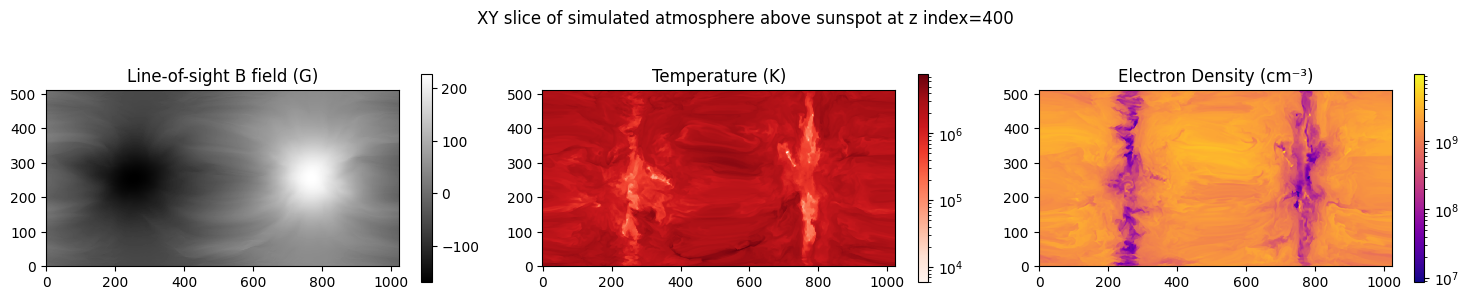

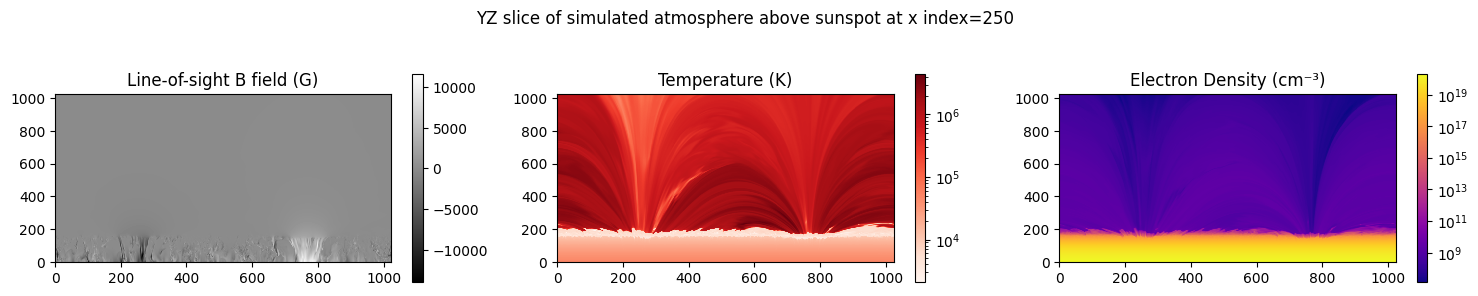

In [461]:
# plot a slice of the atmosphere at z index = 200
zidx = 400
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
im0 = axs[0].imshow(bz[:, :, zidx], cmap='gray')
axs[0].set_title(f"Line-of-sight B field (G)")
fig.colorbar(im0, ax=axs[0], shrink=0.5)
im1 = axs[1].imshow(temp[:, :, zidx], cmap='Reds', norm='log')
axs[1].set_title("Temperature (K)")
fig.colorbar(im1, ax=axs[1], shrink=0.5)
im2 = axs[2].imshow(ne[:, :, zidx], cmap='plasma', norm='log')
axs[2].set_title("Electron Density (cm⁻³)")
fig.colorbar(im2, ax=axs[2], shrink=0.5)
plt.suptitle(f'XY slice of simulated atmosphere above sunspot at z index={zidx}')
plt.tight_layout(rect=[0, 0, 1, 1.2])
plt.show()

xidx = 250
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
im0 = axs[0].imshow(bz[xidx, :, :].T, cmap='gray', aspect=0.5)
axs[0].set_title(f"Line-of-sight B field (G)")
fig.colorbar(im0, ax=axs[0], shrink=0.5)
im1 = axs[1].imshow(temp[xidx, :, :].T, cmap='Reds', norm='log', aspect=0.5)
axs[1].set_title("Temperature (K)")
fig.colorbar(im1, ax=axs[1], shrink=0.5)
im2 = axs[2].imshow(ne[xidx, :, :].T, cmap='plasma', norm='log', aspect=0.5)
axs[2].set_title("Electron Density (cm⁻³)")
fig.colorbar(im2, ax=axs[2], shrink=0.5)
plt.suptitle(f'YZ slice of simulated atmosphere above sunspot at x index={xidx}')
plt.tight_layout(rect=[0, 0, 1, 1.2])
plt.show()

### Synthesize bremsstrahlung, gyroresonance, and faraday rotation

Generating rays through z axis...
[⎯] - creating rays... 5/5 quantities - done
Synthesizing at 1GHz (1e9Hz)...
[⎯] - synthesizing... - done
done


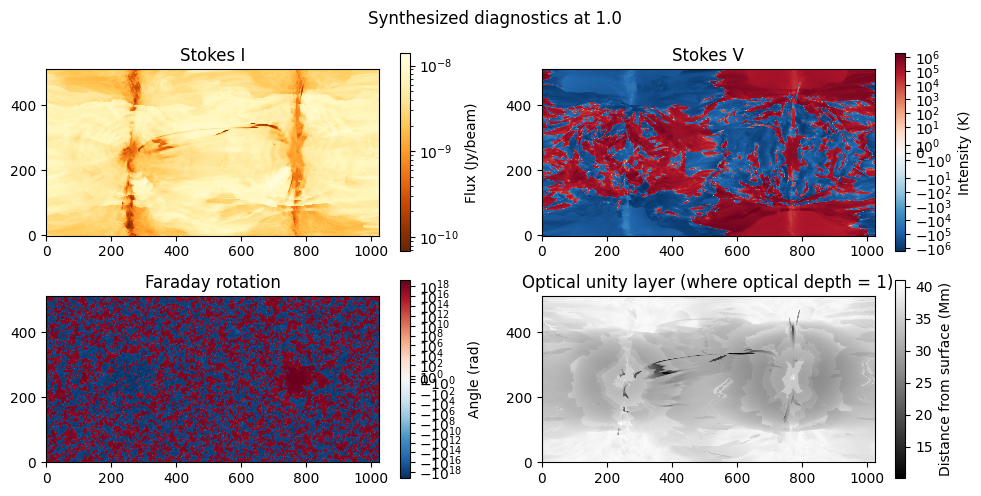

In [462]:
import pysolrad
from importlib import reload
reload(pysolrad)

print('Generating rays through z axis...')
rays = pysolrad.RayCollection(temp, btot, bz, ne, dl, axis = 2) # integrate through z axis (axis=2): generate image looking in the xy plane
print('Synthesizing at 1GHz (1e9Hz)...')
img = pysolrad.synthesize(rays, v=1e9, dogyro=True) # synthesize bremsstrahlung with gyroresonance (dogyro=True)
print('done')

# image is in xy plane by default
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
im0 = axs[0, 0].imshow(img.I.to('Jy/beam'), cmap='YlOrBr_r', norm='log')
axs[0, 0].set_title('Stokes I')
fig.colorbar(im0, ax=axs[0, 0], label='Flux (Jy/beam)')
im1 = axs[0, 1].imshow(img.V, cmap='RdBu_r', norm='symlog')
axs[0, 1].set_title('Stokes V')
fig.colorbar(im1, ax=axs[0, 1], label='Intensity (K)')
im2 = axs[1, 0].imshow(img.faraday, cmap='RdBu_r', norm='symlog')
axs[1, 0].set_title('Faraday rotation')
fig.colorbar(im2, ax=axs[1, 0], label='Angle (rad)')
im3 = axs[1, 1].imshow(img.unity.to('Mm'), cmap='gray')
axs[1, 1].set_title('Optical unity layer (where optical depth = 1)')
fig.colorbar(im3, ax=axs[1, 1], label='Distance from surface (Mm)')
plt.suptitle(f'Synthesized diagnostics at {str(pysolrad.Quantity(img.v, 'Hz').to('GHz'))}')
plt.tight_layout()
plt.show()

### Generate image in xz plane

Change `axis` when creating a `RayCollection` to change which axis to integrate through (defaults to last axis).

Generating rays through y axis...
[⎯] - creating rays... 5/5 quantities - done
Synthesizing at 1GHz (1e9Hz)...
[⎯] - synthesizing... - done
done


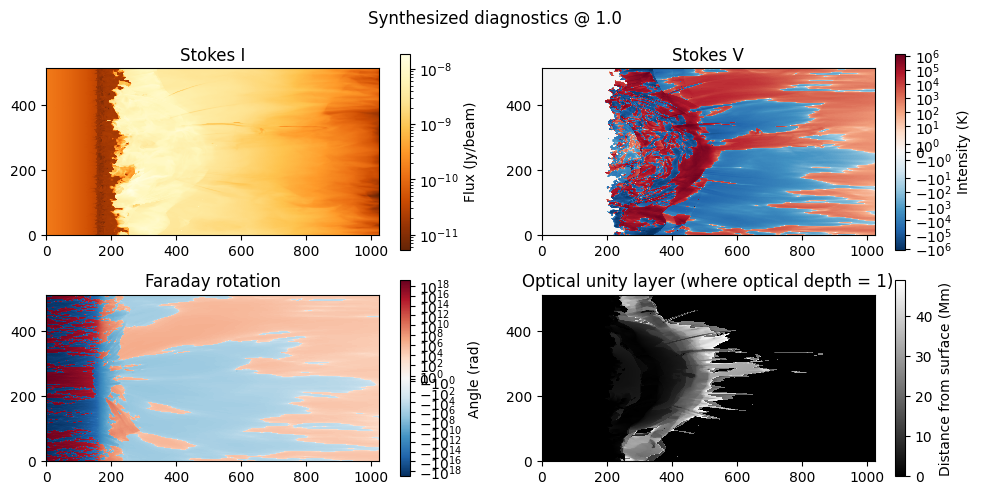

In [463]:
print('Generating rays through y axis...')
yrays = pysolrad.RayCollection(temp, btot, bz, ne, dl, axis = 1) # integrate through y axis
print('Synthesizing at 1GHz (1e9Hz)...')
img = pysolrad.synthesize(yrays, v=1e9, dogyro=True) # synthesize bremsstrahlung with gyroresonance (dogyro)
print('done')

fig, axs = plt.subplots(2, 2, figsize=(10, 5))
im0 = axs[0, 0].imshow(img.I.to('Jy/beam'), cmap='YlOrBr_r', norm='log')
axs[0, 0].set_title('Stokes I')
fig.colorbar(im0, ax=axs[0, 0], label='Flux (Jy/beam)')
im1 = axs[0, 1].imshow(img.V, cmap='RdBu_r', norm='symlog')
axs[0, 1].set_title('Stokes V')
fig.colorbar(im1, ax=axs[0, 1], label='Intensity (K)')
im2 = axs[1, 0].imshow(img.faraday, cmap='RdBu_r', norm='symlog')
axs[1, 0].set_title('Faraday rotation')
fig.colorbar(im2, ax=axs[1, 0], label='Angle (rad)')
im3 = axs[1, 1].imshow(img.unity.to('Mm'), cmap='gray')
axs[1, 1].set_title('Optical unity layer (where optical depth = 1)')
fig.colorbar(im3, ax=axs[1, 1], label='Distance from surface (Mm)')
plt.suptitle(f'Synthesized diagnostics @ {str(pysolrad.Quantity(img.v, 'Hz').to('GHz'))}')
plt.tight_layout()
plt.show()

### Sampling different frequencies for a single line-of-sight

[⎯] - creating rays... 5/5 quantities - done
[⎯] - synthesizing... - done


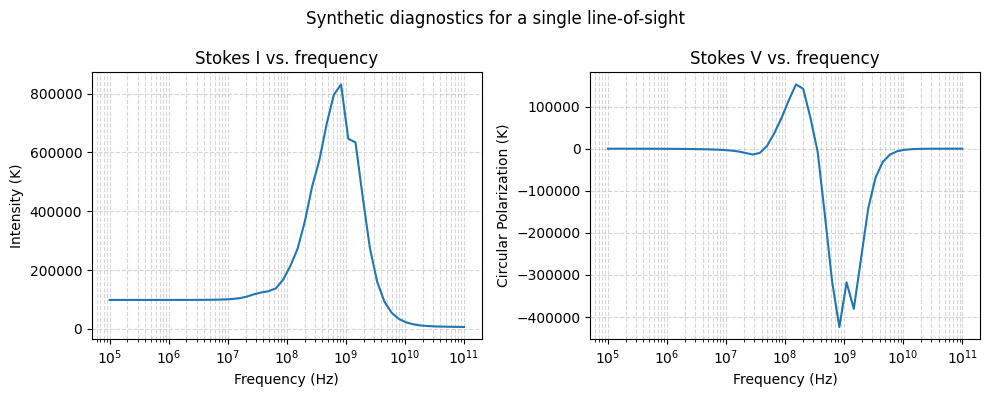

In [582]:
from importlib import reload
reload(pysolrad)

vs = np.logspace(5, 11, 50) # frequencies to sample
ix, iy = 200, 200 # index of single LOS to select
ltemp, lbtot, lbz, lne = temp[ix, iy], btot[ix, iy], bz[ix, iy], ne[ix, iy]
lrays = pysolrad.RayCollection(ltemp, lbtot, lbz, lne, dl)
images = pysolrad.synthesize_range(lrays, vs, dogyro=False)
fields ={'I': ('Stokes I vs. frequency', 'Intensity (K)'), 'V': ('Stokes V vs. frequency', 'Circular Polarization (K)')}
plt.figure(figsize=(10, 4))
for i, field in enumerate(fields, 1):
    vals = [getattr(img, field) for img in images]
    plt.subplot(1, 2, i)
    plt.plot(vs, vals)
    plt.title(fields[field][0])
    plt.ylabel(fields[field][1])
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.xscale('log')
    plt.xlabel('Frequency (Hz)')
plt.suptitle('Synthetic diagnostics for a single line-of-sight')
plt.tight_layout()
plt.show()

### 1D magnetic field inversion

$P=n\frac{2.8\times 10^6}{v}B_{\text{los}}$ where spectral index $n\equiv -\frac{\partial{\log T_b}}{\partial{\log v}}$ and $P=\frac{V}{I}$

from Chapter 6 of [Solar and Space Weather Radio Physics](https://drive.google.com/file/d/1nPEj6RIKA_eOtnwODCnCgedhT0LWunM2/view)

(524288, 1024)


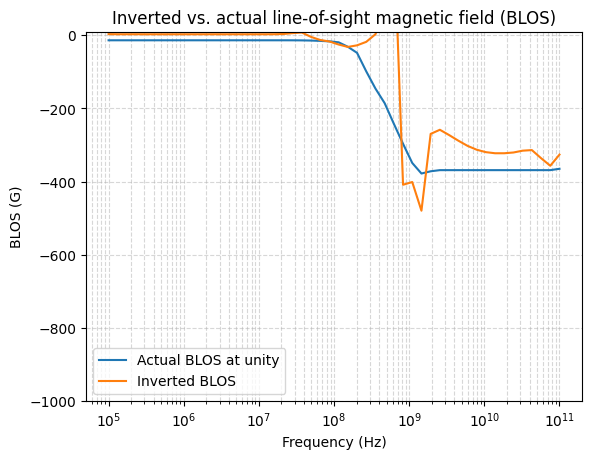

21.26Mm


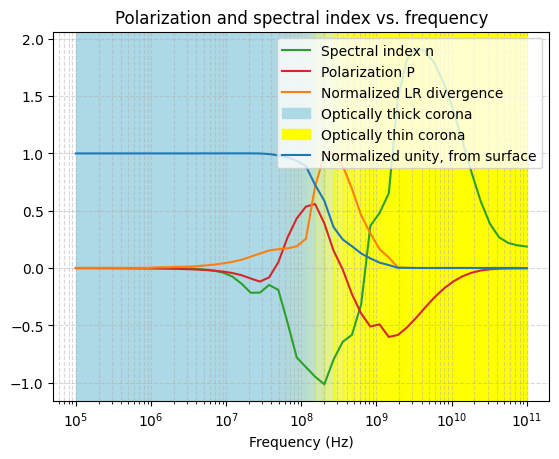

In [ ]:
reload(pysolrad)
inverted_blos = pysolrad.invert_blos(images)
print(rays.fblos.shape)
blos_at_unity = pysolrad.get_quantity_at_unity(lrays, 'blos', images)
spectral_idx = pysolrad.get_spectral_idx(images)
P = images.V/images.I

plt.figure()
plt.plot(vs, blos_at_unity, label='Actual BLOS at unity')
plt.plot(vs, inverted_blos, label='Inverted BLOS')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('BLOS (G)')
plt.legend()
plt.title('Inverted vs. actual line-of-sight magnetic field (BLOS)')
plt.show()

plt.figure()
plt.plot(vs, spectral_idx, color='tab:green', label='Spectral index n')
plt.plot(vs, images.P, color='tab:red', label='Polarization P')
diverge = images.unity.left.to('Mm') - images.unity.right.to('Mm')
print(diverge.max())
diverge /= diverge.max()
plt.plot(vs, diverge, color='tab:orange', label='Normalized LR divergence')
unity = images.unity
unity_normalized = (unity - np.min(unity)) / (np.max(unity) - np.min(unity))
label_done = False
for i in range(len(vs) - 1):
    plt.axvspan(vs[i], vs[i+1], color='lightblue', alpha=float(unity_normalized[i]), label='Optically thick corona' if i == 0 else None)
    plt.axvspan(vs[i], vs[i+1], color='yellow', alpha=1-float(unity_normalized[i]), label='Optically thin corona' if i == len(vs) - 2 else None)
plt.plot(vs, unity_normalized, color='tab:blue', label='Normalized unity, from surface')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.title('Polarization and spectral index vs. frequency')
plt.xlabel('Frequency (Hz)')
plt.legend()
plt.xscale('log')
plt.show()

### 2D magnetic field inversion

In [ ]:
reload(pysolrad)

freq_range = np.logspace(7, 12, 10) # frequencies to sample
images = pysolrad.synthesize_range(rays, freq_range)
inverted_blos_collection = pysolrad.invert_blos(images)
blos_at_unity_collection = pysolrad.get_quantity_at_unity(rays, 'blos', images)

[⎯] - synthesizing...

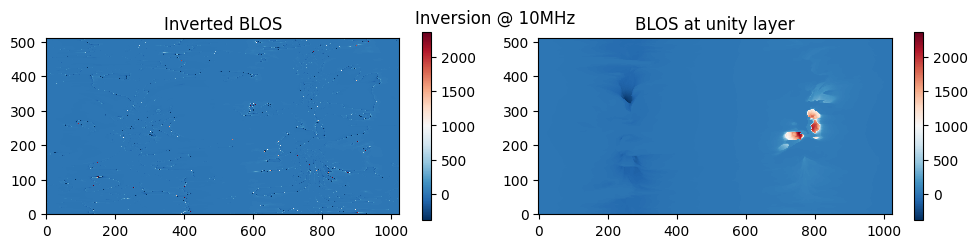

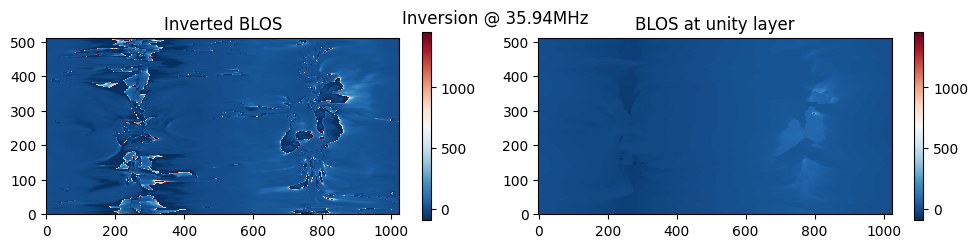

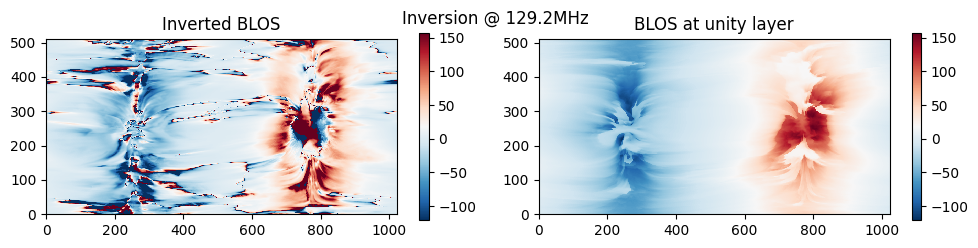

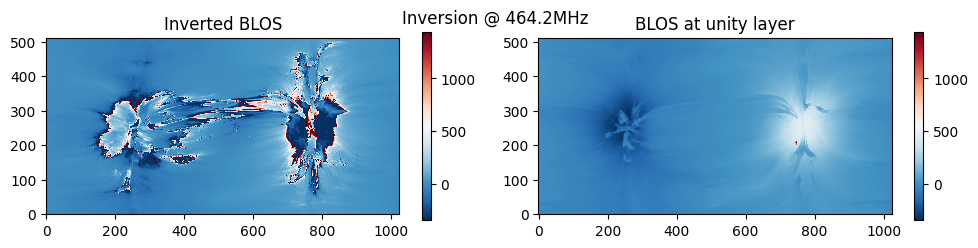

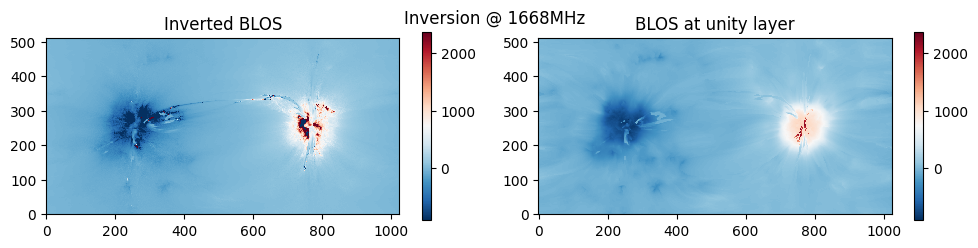

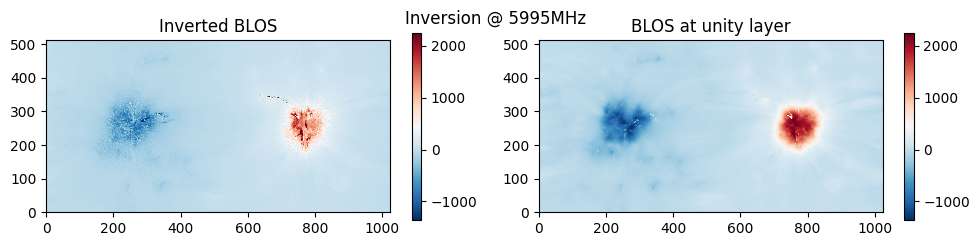

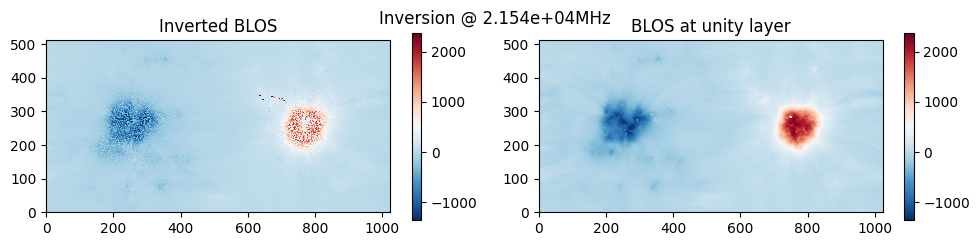

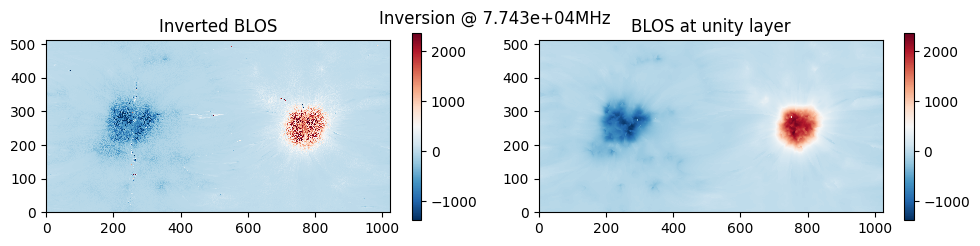

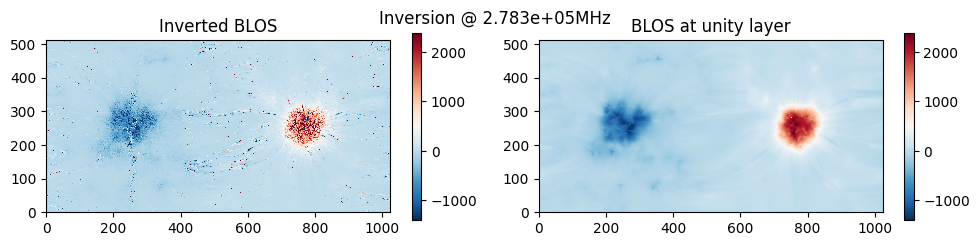

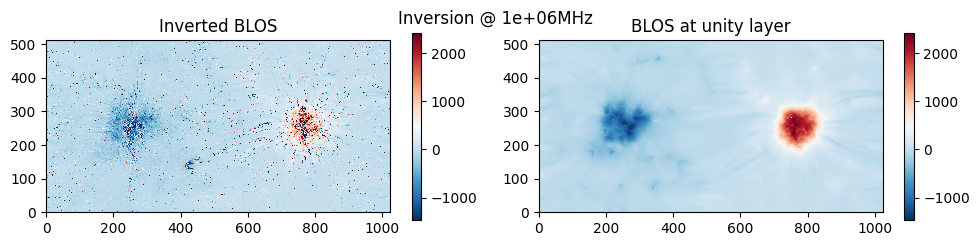

In [575]:
for idx in range(len(images)):
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    inverted_blos = inverted_blos_collection[idx]
    blos_at_unity = blos_at_unity_collection[idx]
    im0 = axs[0].imshow(inverted_blos, origin='lower', cmap='RdBu_r', vmax=blos_at_unity.max(), vmin=blos_at_unity.min())
    axs[0].set_title(f"Inverted BLOS")
    fig.colorbar(im0, ax=axs[0], shrink=0.2)
    im1 = axs[1].imshow(blos_at_unity, origin='lower', cmap='RdBu_r')
    axs[1].set_title(f"BLOS at unity layer")
    fig.colorbar(im1, ax=axs[1], shrink=0.2)
    plt.suptitle(f"Inversion @ {str(pysolrad.Quantity(images.v[idx], 'Hz').to('MHz'))}", y=0.6)
    plt.tight_layout()
    plt.show()